<a href="https://colab.research.google.com/github/poojadeshpande2020/waste_classification/blob/main/trash_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount google drive
### First upload the zip file with all the images onto google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Unzip the file -- All the contents are now in the google drive

In [ ]:
!unzip -uq "/content/drive/My Drive/DATASET.zip" -d "/content/drive/My Drive/trash_classifier"

In [2]:
#RUN
#Import required libraries
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import os
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
import math

sns.set_style({'font.family':'sans-serif', 'font.sans-serif':  'DejaVu Sans'})
sns.set_context('talk')



# This section demonstrates the  creation of a test directory from the validation images



In [3]:
#Paths to the directories
base_dir = '/content/drive/My Drive/trash_classifier/DATASET/DATASET'

train  = os.path.join(base_dir,'TRAIN')
validation = os.path.join(base_dir,'TEST')
test = os.path.join(base_dir , 'tests')

In [ ]:
#Create test directory
# os.mkdir(test)

In [4]:
#RUN
#Count number of images in the training directories

l = ['O','R']
count = 0


for d in l:
    files = os.listdir(os.path.join(train,d)) 
    count = count + len(files)
 
print("Total number of files in the training directory : {}".format(count))

Total number of files in the training directory : 22564


### Pull 20 files randomnly from each class in the validation folder and move it to the test directory

In [ ]:
# for dname in l:
#     src = os.path.join(validation,dname)
#     dst = test

#     #Number of files in the class directory
#     length = len(os.listdir(src))
    
#     #Extract 500 random files
#     all_files = np.array(os.listdir(src))
#     indices = random.sample(range(0,length),10)
#     files = list(all_files[indices])
      
#     for f in files:
#         shutil.move(os.path.join(src,f),dst)

In [5]:
#RUN ALL
#Number of files in the validation directory
count_validation = 0
count_training = 0
for d in l:
    validation_files = os.listdir(os.path.join(validation,d))
    training_files = os.listdir(os.path.join(train,d))
    count_validation = count_validation + len(validation_files)
    count_training = count_training + len(training_files)
print("Number of files in the final training set : {}".format(count_training))
print("Number of files in the final validation set : {}".format(count_validation))

#Test directory     
                   
test_cases = os.listdir(test)
print("Total number of files in the test directory : {}".format(len(test_cases)))

Number of files in the final training set : 22564
Number of files in the final validation set : 2493
Total number of files in the test directory : 20


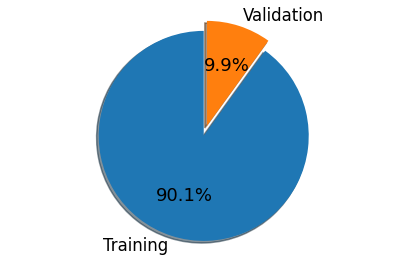

In [6]:
# Pie chart
labels = ['Training','Validation']
sizes = [(count_training),(count_validation)]
# only "explode" the 2nd slice (i.e. 'Hogs')
explode = (0.1,0)  
sizes
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()

# EDA

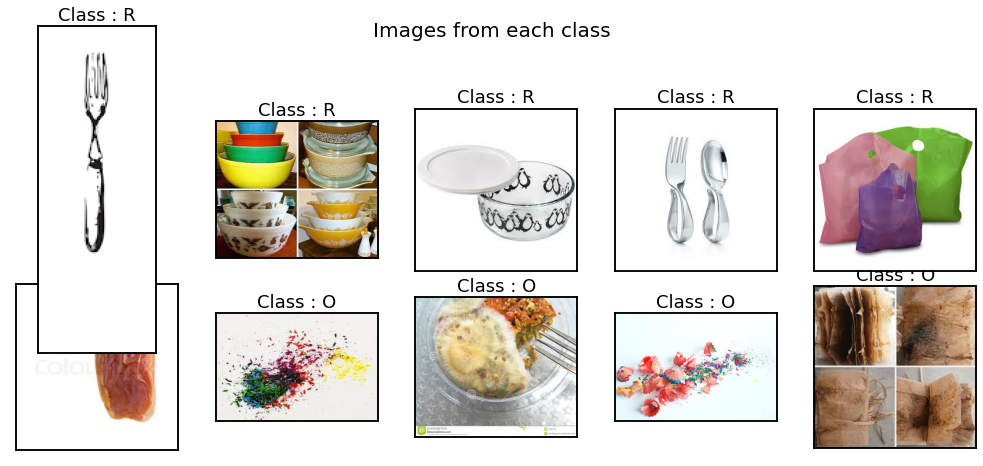

In [7]:
#Display pictures from each class
classes = ['O','R']
fig = plt.figure(figsize = (14,10))

for i,c in enumerate(classes):
    class_dir = os.path.join(train,c)
    for x in range(5):
      img_dir = os.path.join(class_dir,os.listdir(class_dir)[x])
      img = load_img(img_dir)
      array = img_to_array(img)
      array = array/255
      ax = fig.add_subplot(i+1,5,x+1)
      ax.imshow(array)
      ax.set_title("Class : {}".format(c))
      ax.set_xticks([])
      ax.set_yticks([])
    
fig.suptitle("Images from each class",fontsize = 20)
fig.tight_layout()
plt.savefig('training_images.png')
plt.show()


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


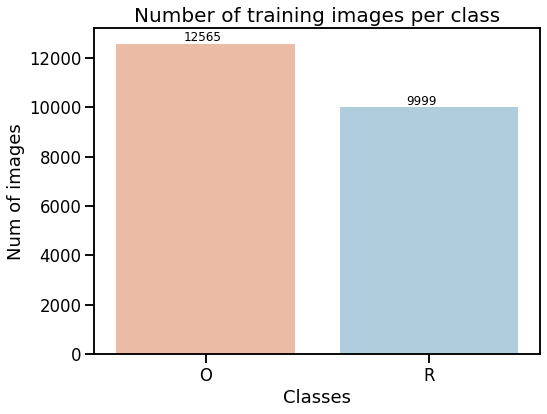

In [8]:
#Number of training images in each class. Is this an imbalanced class problem?
num_files = []
for c in classes:
    files = os.listdir(os.path.join(train,c))
    num_files.append(len(files))

plt.figure(figsize = (8,6))
sns.barplot(classes,num_files,palette = 'RdBu')
for i in range(len(classes)):
    plt.text(i-0.1,num_files[i]+100,num_files[i],fontsize = 12)
plt.title("Number of training images per class",fontsize = 20)
plt.xlabel("Classes")
plt.ylabel("Num of images")
plt.grid(False)
plt.savefig('no_training_images.png')
plt.show()


In [9]:
#DImensions of the original image
image = os.listdir(os.path.join(train,'O'))[0]
img = load_img(os.path.join(train,'O',image))
array = img_to_array(img)
print("Dimensions of the original image : {}".format(array.shape))

Dimensions of the original image : (227, 222, 3)


# Data Pre processing and Augmentation

In [10]:
#ImageDataGenerator to preprocess the images for inputting into the model
train_datagen = ImageDataGenerator(rescale = 1./255,width_shift_range=[-50,50],height_shift_range=0.5,horizontal_flip=True,rotation_range=90,brightness_range=[0.2,0.6])
validation_datagen = ImageDataGenerator(rescale = 1./255,width_shift_range=[-50,50],height_shift_range=0.5,horizontal_flip=True,rotation_range=90,brightness_range=[0.2,0.6])

train_generator = train_datagen.flow_from_directory(
                     directory=train,
                     target_size=(224,224),
                     color_mode="rgb",
                     batch_size=128,
                     class_mode="binary",
                     shuffle=True,
                     seed=123)

validation_generator = validation_datagen.flow_from_directory(
                            directory=validation,
                            target_size=(224,224),
                            color_mode="rgb",
                            batch_size=128,
                            class_mode="binary",
                            shuffle=True,
                            seed=123)



Found 22564 images belonging to 2 classes.
Found 2493 images belonging to 2 classes.


In [11]:
for data_batch,labels_batch in train_generator:
    print("Training data dimension : {}".format(data_batch.shape))
    print("Labels dimension : {}".format(labels_batch.shape))
    break

Training data dimension : (128, 224, 224, 3)
Labels dimension : (128,)


# Model building : Transfer Learning

In [13]:
TRAIN_DATA_DIR = train
VALIDATION_DATA_DIR = validation
TRAIN_SAMPLES = 22564
VALIDATION_SAMPLES = 2493
NUM_CLASSES = 2
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE_TRAIN = 128
BATCH_SIZE_VAL = 128

In [14]:
def model_maker():
    base_model = MobileNet(include_top=False, input_shape =
(IMG_WIDTH,IMG_HEIGHT,3))
    for layer in base_model.layers[:]:
        layer.trainable = False # Freeze the layers
    input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Dense(64, activation='relu')(custom_model)
    custom_model = Dropout(0.5)(custom_model)
    predictions = Dense(1, activation='sigmoid')(custom_model)
    return Model(inputs=input, outputs=predictions)

In [15]:
model = model_maker()
model.compile(loss='binary_crossentropy',
              optimizer= optimizers.Adam(lr=0.001),
              metrics=['acc'])
num_steps_train = math.ceil(float(TRAIN_SAMPLES)/BATCH_SIZE_TRAIN) 
num_steps_val = math.ceil(float(VALIDATION_SAMPLES/BATCH_SIZE_VAL))
history = model.fit_generator(train_generator,
                    steps_per_epoch = num_steps_train,
                    epochs=5,
                    validation_data = validation_generator,
                    validation_steps = num_steps_val)

17227776/17225924 [==============================] - 0s 0us/step
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
177/177 [==============================] - 6689s 38s/step - loss: 0.3155 - acc: 0.8714 - val_loss: 0.3240 - val_acc: 0.8805
Epoch 2/5
177/177 [==============================] - 1240s 7s/step - loss: 0.2591 - acc: 0.8961 - val_loss: 0.2719 - val_acc: 0.8865
Epoch 3/5
177/177 [==============================] - 1231s 7s/step - loss: 0.2451 - acc: 0.9037 - val_loss: 0.2765 - val_acc: 0.8845
Epoch 4/5
177/177 [==============================] - 1229s 7s/step - loss: 0.2410 - acc: 0.9054 - val_loss: 0.2498 - val_acc: 0.9118
Epoch 5/5
177/177 [==============================] - 1230s 7s/step - loss: 0.2298 - acc: 0.9103 - val_loss: 0.2719 - val_acc: 0.8897


In [16]:
#Save the model
model.save("trash_classifier_model.h5")
print("Saved model to disk")


Saved model to disk


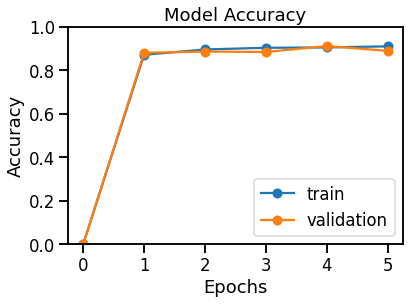

In [27]:
#Plot model accuracy
plt.plot([0]+history.history['acc'],marker = 'o')
plt.plot([0]+history.history['val_acc'],marker = 'o')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['train','validation'])
plt.ylim(0,1)
plt.savefig('acc.png')
plt.show()

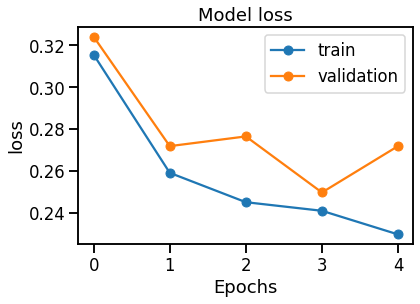

In [28]:
#Plot model loss
plt.plot(history.history['loss'],marker = 'o')
plt.plot(history.history['val_loss'],marker = 'o')
plt.title("Model loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend(['train','validation'])
plt.savefig('loss.png')
plt.show()

# Experimenting with a smaller network

In [69]:
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation = 'relu',input_shape = (224,224,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
# model.add(layers.Conv2D(64,(3,3),activation = 'relu'))
# model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64,activation = 'relu'))
model.add(layers.Dense(1,activation = 'sigmoid'))

In [70]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 186624)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                11944000  
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [71]:
#Compile the model, with Adam optimizer and a learning rate of 0.001
model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.Adam(lr=0.001),
              metrics = ['acc'],)

In [72]:
#Fit the model
history_2 = model.fit_generator(
            train_generator, 
            steps_per_epoch=math.ceil(22564/128),
            epochs=5,
            validation_data=validation_generator,
            validation_steps=math.ceil(2493/128))

Epoch 1/5
177/177 [==============================] - 1748s 10s/step - loss: 0.5272 - acc: 0.7742 - val_loss: 0.4323 - val_acc: 0.8291
Epoch 2/5
177/177 [==============================] - 1736s 10s/step - loss: 0.4410 - acc: 0.8029 - val_loss: 0.3703 - val_acc: 0.8400
Epoch 3/5
177/177 [==============================] - 1731s 10s/step - loss: 0.4232 - acc: 0.8079 - val_loss: 0.3984 - val_acc: 0.8235
Epoch 4/5
177/177 [==============================] - 1731s 10s/step - loss: 0.4094 - acc: 0.8151 - val_loss: 0.3538 - val_acc: 0.8548
Epoch 5/5
177/177 [==============================] - 1727s 10s/step - loss: 0.4001 - acc: 0.8250 - val_loss: 0.3545 - val_acc: 0.8560


The above model shows promise. The accuracy may increase if run for more number of epochs.

In [ ]:
#Save the model
model.save("trash_classifier_model_2.h5")
print("Saved model to disk")


Saved model to disk


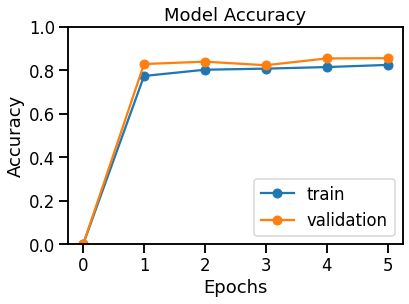

In [75]:
#Plot model accuracy
plt.plot([0]+history_2.history['acc'],marker = 'o')
plt.plot([0]+history_2.history['val_acc'],marker = 'o')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.legend(['train','validation'])
plt.show()

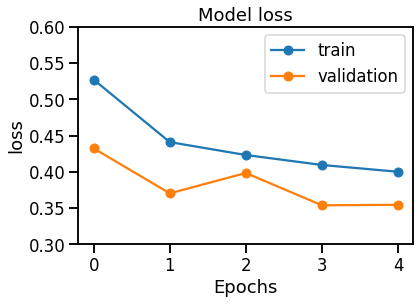

In [82]:
#Plot model loss
plt.plot(history_2.history['loss'],marker = 'o')
plt.plot(history_2.history['val_loss'],marker = 'o')
plt.title("Model loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.ylim(0.3,0.6)
plt.legend(['train','validation'])
plt.show()

# Predictions

In [37]:
def process_image(image_path):
  
  img = load_img(image_path,target_size = (224,224))
  array = img_to_array(img)
  array = array/255
  plt.imshow(array)
  array = array.reshape((1,) + array.shape)
  
  return array

The material is recyclable


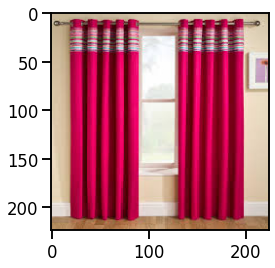

In [64]:
#Predict class for a random image from the test set
num_files_test = len(os.listdir(test))
n = random.randint(1,num_files_test)

image_path = os.path.join(test,os.listdir(test)[n])
array = process_image(image_path)

result = (model.predict(array))

if result[0]>=0.5:
  print("The material is recyclable")
else:
  print("The material is organic")

